In [38]:
import pandas as pd
import numpy as np 
import re 



import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg





import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# 1. Prepare Data

## 1.1 Import

In [90]:

df=pd.read_csv("data\SHIBUSDT_d_2021_5_1682698627.csv", index_col="timestamp", parse_dates=True)
df.index.freq='d'


## 1.2 Explore

Text(0, 0.5, 'Correlation Coefficient')

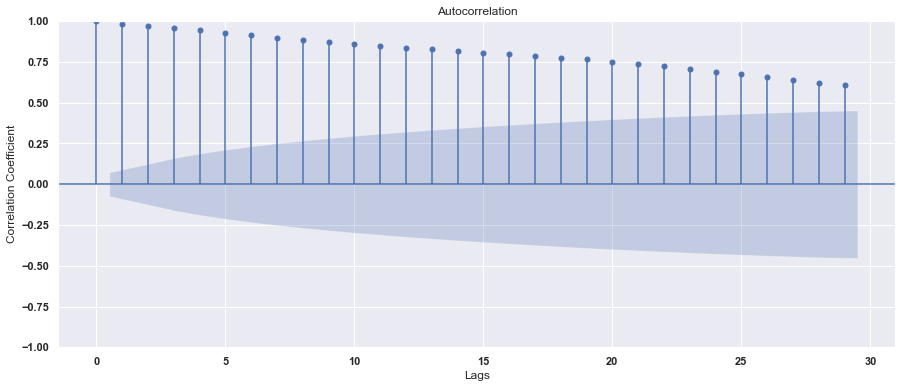

In [91]:
fig,ax=plt.subplots(figsize=(15,6))
plot_acf(df.dropna(),ax=ax)
plt.xlabel("Lags")
plt.ylabel("Correlation Coefficient")

Text(0, 0.5, 'Correlation Coefficient')

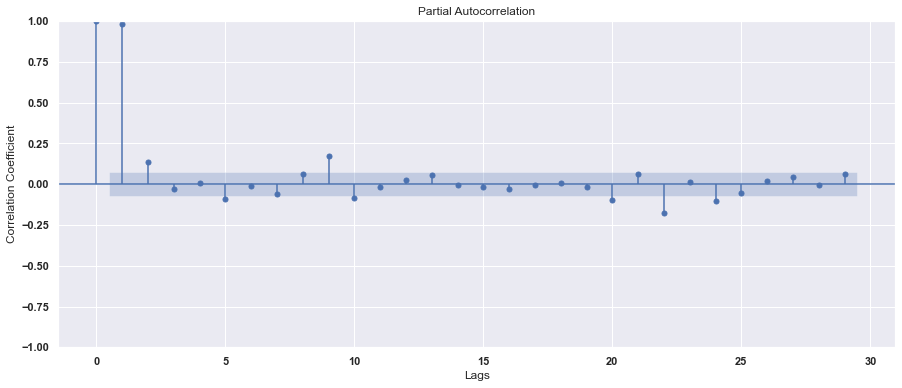

In [92]:
fig,ax=plt.subplots(figsize=(15,6))
plot_pacf(df.dropna(),ax=ax)
plt.xlabel("Lags")
plt.ylabel("Correlation Coefficient")
#lag 6 is only on pacf graph, so we will use 6 as our lag value

## 1.3 Split

In [93]:
cut=int(len(df)*0.8)
y_train=df.iloc[:cut]
y_test=df.iloc[cut:]

# 2.Model

## 2.1 Baseline

In [112]:
#calculate mean baseline
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean Close price:", round(y_train_mean[0],6))
print("Baseline MAE:", round(mae_baseline,6))

Mean Close price: 1.8e-05
Baseline MAE: 1e-05


## 2.2 Iterate

In [113]:
model=AutoReg(y_train,lags=14).fit()



In [114]:
model.predict()

timestamp
2021-05-10         NaN
2021-05-11         NaN
2021-05-12         NaN
2021-05-13         NaN
2021-05-14         NaN
                ...   
2022-11-30    0.000009
2022-12-01    0.000009
2022-12-02    0.000009
2022-12-03    0.000009
2022-12-04    0.000009
Freq: D, Length: 574, dtype: float64

In [121]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train[14:], y_pred)
print(f"Traning MAE: {training_mae:.11f}")

Traning MAE: 0.00000100767


In [122]:
y_train_resid=model.resid
y_train_resid

timestamp
2021-05-24    2.882850e-06
2021-05-25   -1.102031e-06
2021-05-26   -1.732309e-06
2021-05-27   -1.400947e-06
2021-05-28   -2.574192e-07
                  ...     
2022-11-30    3.844974e-07
2022-12-01   -2.766065e-07
2022-12-02   -1.072721e-07
2022-12-03   -2.218828e-07
2022-12-04    9.319077e-09
Freq: D, Length: 560, dtype: float64

## 2.3 Evaluate 

In [125]:
y_pred_test=model.predict(y_test.index.min(),y_test.index.max())
test_mae=mean_absolute_error(y_test,y_pred_test)
print(f'Test MAE:===> {test_mae}')

Test MAE:===> 3.4262108175436817e-06


In [132]:
df_pred_test= pd.DataFrame({"y_test":y_test.squeeze() ,"y_pred":y_pred_test} ,index=y_test.index)
df_pred_test





,y_test,y_pred
timestamp,,
2022-12-05,0.000009,0.000009
2022-12-06,0.000009,0.000010
2022-12-07,0.000009,0.000010
2022-12-08,0.000009,0.000010
2022-12-09,0.000009,0.000010
...,...,...
2023-04-23,0.000010,0.000017
2023-04-24,0.000010,0.000017
2023-04-25,0.000010,0.000017


In [133]:
fig=px.line(df_pred_test)
fig.show()

# Perform "WFV"===> Walk Forward Validation

In [146]:
#lags should be a param as same as cutoff i think
# walk forward validation
from tqdm import tqdm
y_test=y_test.squeeze()
y_pred_wfv=pd.Series()
history=y_train.copy().squeeze()
for i in tqdm(range(len(y_test))):
    model=AutoReg(history,lags=14).fit()
    next_pred=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_pred)
    history=history.append(y_test[next_pred.index])

100%|██████████| 144/144 [00:01<00:00, 83.28it/s]


# 3. Communicate Results

In [147]:
test_mae_wvf=mean_absolute_error(y_test,y_pred_wfv)
print(f"MAE for Pred V.s TEST==> {test_mae_wvf}")

MAE for Pred V.s TEST==> 2.9491718750295e-07


In [148]:
df_pred_wfv=pd.DataFrame({"y_test":y_test,"y_pred_wfv":y_pred_wfv})
fig=px.line(df_pred_wfv,labels={"Price"})
fig.show()